In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import numpy as np
from pathlib import Path

from matplotlib.colors import LightSource
import pygmt

# sns.set_theme()
# %matplotlib widget
params = {
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'image.origin': "lower",
    "figure.figsize": (4 * 2.5, 3 * 2.5),
    "savefig.bbox": "tight",
    "savefig.dpi": 300,}

matplotlib.rcParams.update(params)


In [2]:
figure_path = Path("figures")

In [3]:
gamma_catalog = pd.read_csv("gamma_catalog.csv", parse_dates=["time"])

In [4]:
standard_catalog = pd.read_csv("quakeflow/standard_catalog.csv", parse_dates=["time"])
standard_catalog["depth_km"] = standard_catalog["depth(m)"] / 1e3
standard_catalog_origin = standard_catalog.copy()
standard_catalog = standard_catalog[(standard_catalog["time"] > gamma_catalog["time"].min()) & (standard_catalog["time"] < gamma_catalog["time"].max())]

In [12]:
print(len(standard_catalog_origin))

9995


In [5]:
seismic_stations = pd.read_json("quakeflow/stations.json", orient="index")
das_loc = pd.read_csv("das_info.csv")

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -119.54162 to -119.541666667
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -118.086798 to -118.083333333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 36.84966 to 36.8458333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 38.4491 to 38.45


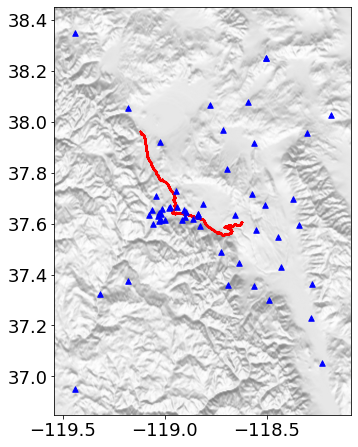

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4 * 2.5, 3 * 2.5))

ls = LightSource(azdeg=0, altdeg=45)

min_longitude = seismic_stations["longitude"].min() - 0.1
max_longitude = seismic_stations["longitude"].max() + 0.1
min_latitude = seismic_stations["latitude"].min() - 0.1
max_latitude = seismic_stations["latitude"].max() + 0.1
region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="15s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
ax.pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

ax.scatter(das_loc["longitude"], das_loc["latitude"], c="r", s=1, marker=".", label="DAS", rasterized=True)
ax.scatter(seismic_stations["longitude"], seismic_stations["latitude"], c="b", s=30, label="Seismometer", marker="^")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_aspect(1.0/np.cos(np.deg2rad(ylim[0])))
plt.savefig(figure_path / "station_map.png")
plt.savefig(figure_path / "station_map.pdf")

In [7]:
hypoDD_ct_catalog = pd.read_csv(
    "quakeflow/hypoDD_ct_catalog.txt",
    sep="\s+",
    names=[
        "ID",
        "LAT",
        "LON",
        "DEPTH",
        "X",
        "Y",
        "Z",
        "EX",
        "EY",
        "EZ",
        "YR",
        "MO",
        "DY",
        "HR",
        "MI",
        "SC",
        "MAG",
        "NCCP",
        "NCCS",
        "NCTP",
        "NCTS",
        "RCC",
        "RCT",
        "CID",
    ],
)
hypoDD_ct_catalog["time"] = hypoDD_ct_catalog.apply(
    lambda x: f'{x["YR"]:04.0f}-{x["MO"]:02.0f}-{x["DY"]:02.0f}T{x["HR"]:02.0f}:{x["MI"]:02.0f}:{min(x["SC"], 59.999):05.3f}',
    axis=1,
)
hypoDD_ct_catalog["time"] = hypoDD_ct_catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
hypoDD_ct_catalog["depth_km"] = hypoDD_ct_catalog["DEPTH"]
hypoDD_ct_catalog["longitude"] = hypoDD_ct_catalog["LON"]
hypoDD_ct_catalog["latitude"] = hypoDD_ct_catalog["LAT"]



In [8]:
quakeflow_catalog_origin = hypoDD_ct_catalog.copy()

In [9]:
# hypoDD_ct_catalog2 = hypoDD_ct_catalog[(hypoDD_ct_catalog["longitude"]>min_longitude) & (hypoDD_ct_catalog["longitude"]<max_longitude) & (hypoDD_ct_catalog["latitude"]>min_latitude) & (hypoDD_ct_catalog["latitude"]<max_latitude) & (hypoDD_ct_catalog["depth_km"] > min_depth) & (hypoDD_ct_catalog["depth_km"] < max_depth)]

# plot_location(hypoDD_ct_catalog2, color="k", size=0.3, fname="figures/hypodd_catalog0", xlim=xlim2, ylim=ylim2, zlim=zlim2, stations=das_loc)

In [10]:
hypoDD_ct_catalog = hypoDD_ct_catalog[(hypoDD_ct_catalog["time"] > gamma_catalog["time"].min()) & (hypoDD_ct_catalog["time"] < gamma_catalog["time"].max())]
quakeflow_catalog = hypoDD_ct_catalog

In [14]:
print(len(quakeflow_catalog_origin))

23704


In [11]:
def plot_location(catalog, color=None, size=10, cmap="viridis", alpha=0.8, fname="catalog", xlim=None, ylim=None, zlim=None, stations=None):
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

    if color is None:
        color = "k"

    axes[0,0].scatter(catalog["longitude"], catalog["latitude"], s=size, c=color, cmap=cmap, alpha=alpha, rasterized=True)
    axes[0,0].set_title(f"Number of events: {len(catalog)}")
    axes[0,0].autoscale(tight=True)
    
    if xlim is None:
        xlim = axes[0,0].get_xlim()
    if ylim is None:
        ylim = axes[0,0].get_ylim()
        
    if stations is not None:
        axes[0, 0].scatter(stations["longitude"], stations["latitude"], s=10, c="b", marker=".", alpha=0.05, rasterized=True)
    axes[0,0].set_xlim(xlim)
    axes[0,0].set_ylim(ylim)

    axes[0,1].scatter(catalog["depth_km"], catalog["latitude"],  s=size, c=color, cmap=cmap, alpha=alpha, rasterized=True)
    axes[0,1].autoscale(tight=True)
    if ylim is not None:
        axes[0,1].set_ylim(ylim)
    if zlim is not None:
        axes[0,1].set_xlim(zlim)

    im = axes[1,0].scatter(catalog["longitude"], catalog["depth_km"], s=size, c=color, cmap=cmap, alpha=alpha, rasterized=True)
    axes[1,0].autoscale(tight=True)    
    if xlim is not None:
        axes[1,0].set_xlim(xlim)
    if zlim is None:
        zlim = axes[1,0].get_ylim()
    else:
        axes[1,0].set_ylim(zlim)
    axes[1,0].invert_yaxis()

    # fig.colorbar(im, ax=axes[1,1], location="right", anchor=(-1, -1))
    axes[1, 1].axis('off')
    fig.tight_layout()

    fig.savefig(fname + ".pdf", bbox_inches='tight', dpi=300)
    fig.savefig(fname + ".png", bbox_inches='tight', dpi=300)

    return xlim, ylim, zlim

In [12]:
# sns.set_theme()
# matplotlib.rcParams.update(params)
# plt.style.use('seaborn')

# print(f"{len(gamma_catalog) = }")
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# vmin = gamma_catalog["time"].min()
# vmax = gamma_catalog["time"].max()
# vmin = datetime(2020, 11, 1)
# vmax = datetime(2021, 2, 1)
# ax.hist(gamma_catalog["time"], range=(vmin, vmax), bins=(vmax-vmin).days, label=f"PhaseNet-DAS: {len(gamma_catalog)}", alpha=1.0)
# ax.hist(hypoDD_ct_catalog["time"], range=(vmin, vmax), bins=(vmax-vmin).days, label=f"QuakeFlow: {len(hypoDD_ct_catalog)}", alpha=0.8)
# ax.hist(standard_catalog["time"], range=(vmin, vmax), bins=(vmax-vmin).days, label=f"Standard: {len(standard_catalog)}", alpha=0.6)
# ax.set_ylabel("Frequency / day")
# # ax.tick_params(axis="x", labelrotation=15)
# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
# ax.legend()
# ax.autoscale(tight=True)
# fig.autofmt_xdate(rotation=15)
# fig.savefig(figure_path / "earthquake_number.pdf", bbox_inches='tight', dpi=300)
# fig.savefig(figure_path / "earthquake_number.png", bbox_inches='tight', dpi=300)


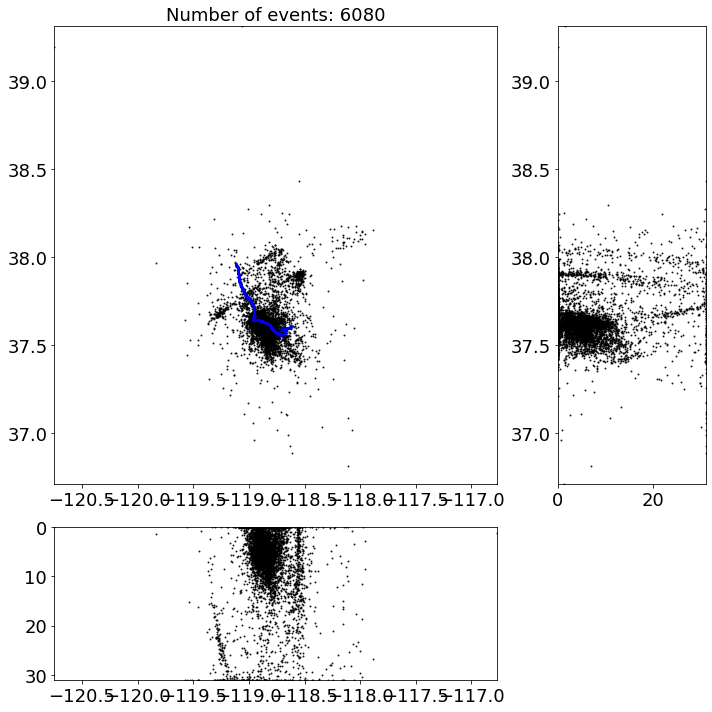

In [13]:
xlim, ylim, zlim = plot_location(gamma_catalog, color="k", size=1, fname="figures/gamma_catalog_das", stations=das_loc)

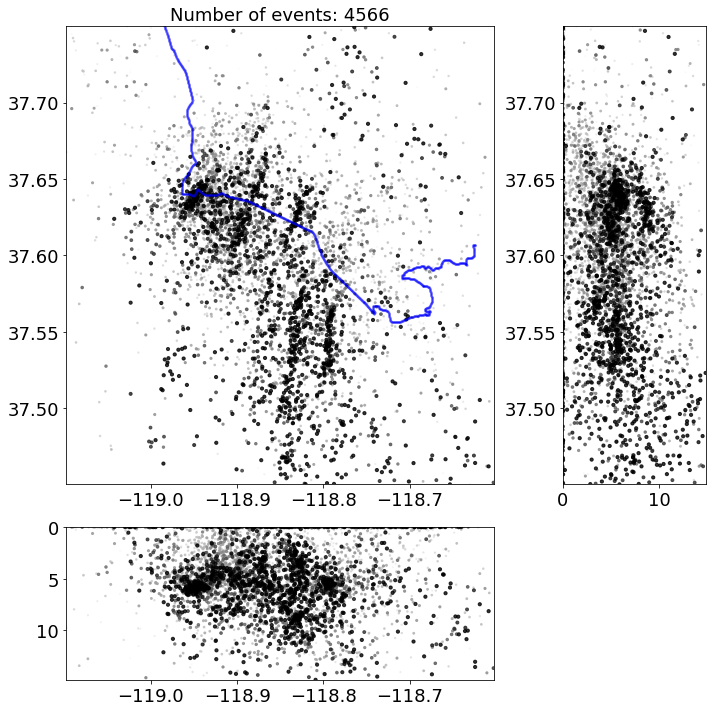

In [14]:
min_longitude = -119.1
max_longitude = -118.6
min_latitude = 37.45
max_latitude = 37.75
min_depth = -0.1
max_depth = 15
gamma_catalog2 = gamma_catalog[(gamma_catalog["longitude"]>min_longitude) & (gamma_catalog["longitude"]<max_longitude) & (gamma_catalog["latitude"]>min_latitude) & (gamma_catalog["latitude"]<max_latitude) & (gamma_catalog["depth_km"] > min_depth) & (gamma_catalog["depth_km"] < max_depth)]
gamma_catalog2 = gamma_catalog2.sort_values("gamma_score")
color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*2) 
size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*2)/(gamma_catalog2["gamma_score"].std()*2)*10
xlim2, ylim2, zlim2 = plot_location(gamma_catalog2, color=color,  size=size, cmap="binary", fname="figures/gamma_catalog_das2", stations=das_loc)

In [41]:
print(gamma_catalog["time"].min())
print(gamma_catalog["time"].max())

2020-10-20 20:02:55.672000
2021-04-12 05:41:15.836000


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


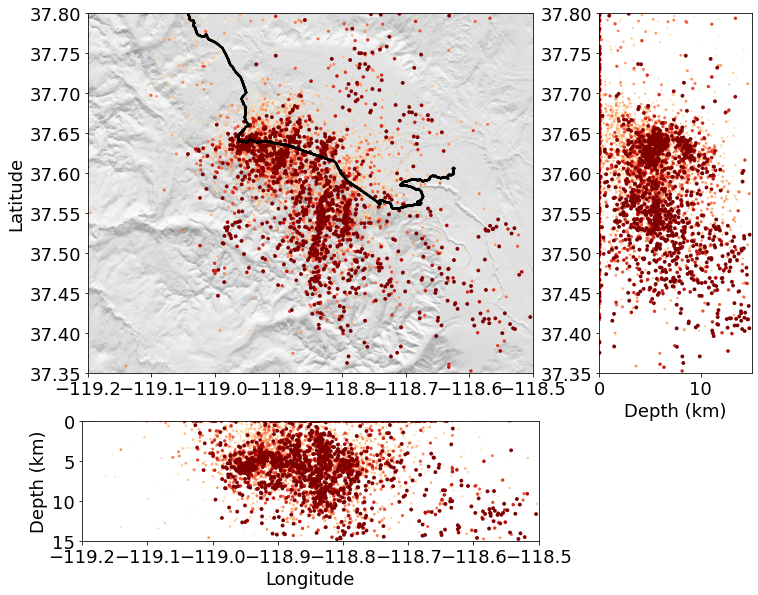

In [30]:
# sns.set_theme("origin")
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.35
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"
gamma_catalog2 = gamma_catalog[(gamma_catalog["longitude"]>min_longitude) & (gamma_catalog["longitude"]<max_longitude) & (gamma_catalog["latitude"]>min_latitude) & (gamma_catalog["latitude"]<max_latitude) & (gamma_catalog["depth_km"] > min_depth) & (gamma_catalog["depth_km"] < max_depth)]
gamma_catalog2 = gamma_catalog2.sort_values("gamma_score")

# events_das2 = events_das[(events_das["longitude"]>min_longitude) & (events_das["longitude"]<max_longitude) & (events_das["latitude"]>min_latitude) & (events_das["latitude"]<max_latitude) & (events_das["depth_km"] > min_depth) & (events_das["depth_km"] < max_depth)]
# # events_das2 = events_das2.sort_values("gamma_score")
# events_mammoth_north2 = events_mammoth_north[(events_mammoth_north["longitude"]>min_longitude) & (events_mammoth_north["longitude"]<max_longitude) & (events_mammoth_north["latitude"]>min_latitude) & (events_mammoth_north["latitude"]<max_latitude) & (events_mammoth_north["depth_km"] > min_depth) & (events_mammoth_north["depth_km"] < max_depth)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*2) 
# color = "red"
size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*2)/(gamma_catalog2["gamma_score"].std()*2)*15
# cmap="Reds"
cmap = "OrRd"
axes[0,0].scatter(gamma_catalog2["longitude"], gamma_catalog2["latitude"], s=size, c=color, cmap=cmap, linewidth=0, label="DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(das_loc["longitude"], das_loc["latitude"], s=2, c="k", alpha=0.5, marker=".", rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0,0].set_ylabel("Latitude")


axes[0,1].scatter(gamma_catalog2["depth_km"], gamma_catalog2["latitude"], s=size, c=color, cmap=cmap,  linewidth=0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(gamma_catalog2["longitude"], gamma_catalog2["depth_km"], s=size, c=color, cmap=cmap, linewidth=0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "gamma_catalog_das.pdf")
fig.savefig(figure_path / "gamma_catalog_das.png")

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


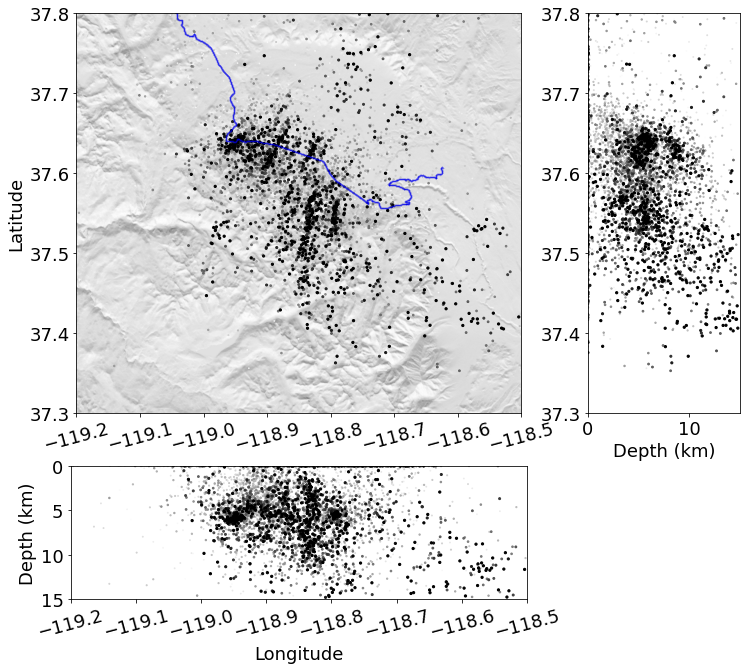

In [40]:
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.3
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"

gamma_catalog2 = gamma_catalog[(gamma_catalog["longitude"]>min_longitude) & (gamma_catalog["longitude"]<max_longitude) & (gamma_catalog["latitude"]>min_latitude) & (gamma_catalog["latitude"]<max_latitude) & (gamma_catalog["depth_km"] > min_depth) & (gamma_catalog["depth_km"] < max_depth)]
gamma_catalog2 = gamma_catalog2.sort_values("gamma_score")

fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

std = 2.5
color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# color = "red"
size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# cmap="Reds"
# cmap = "OrRd"
# cmap = "gray"
cmap = "binary"
axes[0,0].scatter(gamma_catalog2["longitude"], gamma_catalog2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(das_loc["longitude"], das_loc["latitude"], s=2, c="b", marker=".", alpha=0.05, rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0, 0].tick_params(axis="x", labelrotation=15)
axes[0,0].set_ylabel("Latitude")

axes[0,1].scatter(gamma_catalog2["depth_km"], gamma_catalog2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(gamma_catalog2["longitude"], gamma_catalog2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].tick_params(axis="x", labelrotation=15)
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "gamma_catalog_das2.pdf")
fig.savefig(figure_path / "gamma_catalog_das2.png")

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


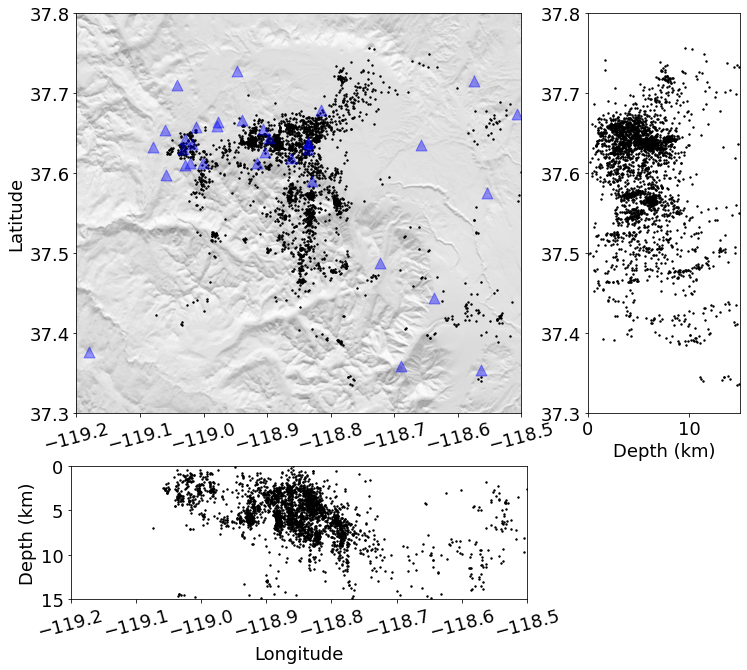

In [38]:
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.3
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"

quakeflow_catalog2 = quakeflow_catalog[(quakeflow_catalog["longitude"]>min_longitude) & (quakeflow_catalog["longitude"]<max_longitude) & (quakeflow_catalog["latitude"]>min_latitude) & (quakeflow_catalog["latitude"]<max_latitude) & (quakeflow_catalog["depth_km"] > min_depth) & (quakeflow_catalog["depth_km"] < max_depth)]
# quakeflow_catalog2 = quakeflow_catalog2.sort_values("gamma_score")

fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

# std = 2.5
# color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# color = "red"
# size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# cmap="Reds"
# cmap = "OrRd"
# cmap = "gray"
size = 2.0
color="k"
cmap="binary"
cmap = "binary"
axes[0,0].scatter(quakeflow_catalog2["longitude"], quakeflow_catalog2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(seismic_stations["longitude"], seismic_stations["latitude"], s=120, c="b", marker="^", alpha=0.4, rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0, 0].tick_params(axis="x", labelrotation=15)
axes[0,0].set_ylabel("Latitude")

axes[0,1].scatter(quakeflow_catalog2["depth_km"], quakeflow_catalog2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(quakeflow_catalog2["longitude"], quakeflow_catalog2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].tick_params(axis="x", labelrotation=15)
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "quakeflow_catalog2.pdf")
fig.savefig(figure_path / "quakeflow_catalog2.png")

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


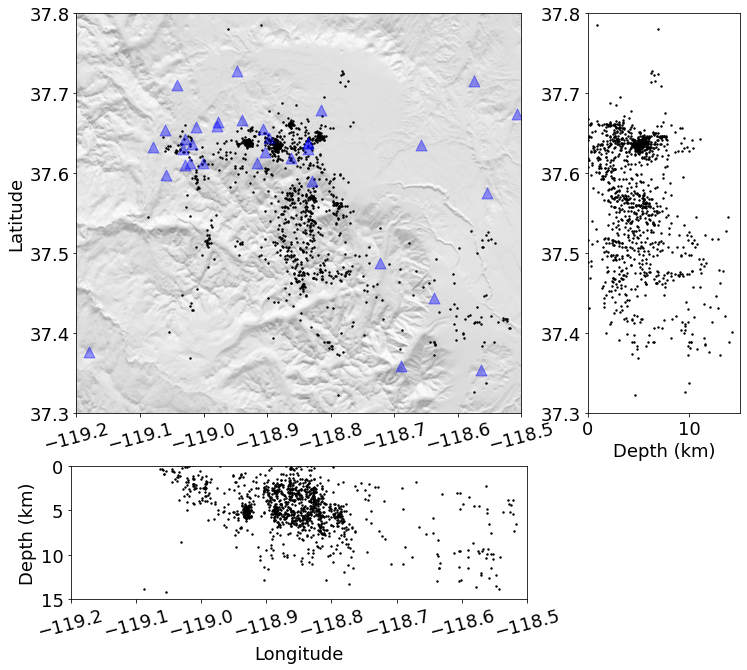

In [35]:
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.3
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"

standard_catalog2 = standard_catalog[(standard_catalog["longitude"]>min_longitude) & (standard_catalog["longitude"]<max_longitude) & (standard_catalog["latitude"]>min_latitude) & (standard_catalog["latitude"]<max_latitude) & (standard_catalog["depth_km"] > min_depth) & (standard_catalog["depth_km"] < max_depth)]

cmap = "viridis_r"
color = standard_catalog2["depth_km"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

# std = 2.5
# color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# color = "red"
# size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# cmap="Reds"
# cmap = "OrRd"
# cmap = "gray"
size = 2.0
color="k"
cmap="binary"
cmap = "binary"
axes[0,0].scatter(standard_catalog2["longitude"], standard_catalog2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(seismic_stations["longitude"], seismic_stations["latitude"], s=120, c="b", marker="^", alpha=0.4, rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0, 0].tick_params(axis="x", labelrotation=15)
axes[0,0].set_ylabel("Latitude")

axes[0,1].scatter(standard_catalog2["depth_km"], standard_catalog2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(standard_catalog2["longitude"], standard_catalog2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].tick_params(axis="x", labelrotation=15)
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "standard_catalog2.pdf")
fig.savefig(figure_path / "standard_catalog2.png")

In [18]:
# # sns.reset_orig()
# # matplotlib.rcParams.update(params)

# min_longitude = -119.2
# max_longitude = -118.5
# min_latitude = 37.3
# max_latitude = 37.8
# min_depth = -0.1
# max_depth = 21
# cmap = "viridis"

# standard_catalog2 = standard_catalog[(standard_catalog["longitude"]>min_longitude) & (standard_catalog["longitude"]<max_longitude) & (standard_catalog["latitude"]>min_latitude) & (standard_catalog["latitude"]<max_latitude) & (standard_catalog["depth_km"] > min_depth) & (standard_catalog["depth_km"] < max_depth)]

# cmap = "viridis_r"
# color = standard_catalog2["depth_km"]

# fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

# region = [min_longitude, max_longitude, min_latitude, max_latitude]
# topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
# x = np.linspace(min_longitude, max_longitude, topo.shape[1])
# y = np.linspace(min_latitude, max_latitude, topo.shape[0])
# dx, dy = 1, 1
# xgrid, ygrid = np.meshgrid(x, y)
# axes[0,0].pcolormesh(
#     xgrid,
#     ygrid,
#     ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
#     vmin=-1,
#     shading="gouraud",
#     cmap="gray",
#     alpha=1.0,
#     antialiased=True,
#     rasterized=True,
# )

# # std = 2.5
# # color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# # color = "red"
# # size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# # cmap="Reds"
# # cmap = "OrRd"
# # cmap = "gray"
# size = 2.0
# color="k"
# cmap="binary"
# cmap = "binary"
# axes[0,0].scatter(standard_catalog2["longitude"], standard_catalog2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
# axes[0,0].autoscale(tight=True)
# xlim = axes[0,0].get_xlim()
# ylim = axes[0,0].get_ylim()
# # zlim = (0, 21)
# # axes[0,0].set_title(f"Number of events: {len(events_das2)}")
# axes[0, 0].scatter(seismic_stations["longitude"], seismic_stations["latitude"], s=120, c="b", marker="^", alpha=0.4, rasterized=True)
# # axes[0, 0].axis("scaled")
# axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
# axes[0,0].set_xlim(xlim)
# axes[0,0].set_ylim(ylim)
# # axes[0, 0].legend(markerscale=5)
# axes[0, 0].tick_params(axis="x", labelrotation=15)
# axes[0,0].set_ylabel("Latitude")

# axes[0,1].scatter(standard_catalog2["depth_km"], standard_catalog2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
# axes[0,1].autoscale(tight=True)
# axes[0,1].set_ylim(ylim)
# axes[0,1].set_xlim([0, 20])
# axes[0,1].set_xlabel("Depth (km)")

# axes[1,0].scatter(standard_catalog2["longitude"], standard_catalog2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
# axes[1,0].autoscale(tight=True)    
# axes[1,0].set_xlim(xlim)
# axes[1,0].set_ylim([0, 20])
# axes[1,0].invert_yaxis()
# axes[1,0].set_ylabel("Depth (km)")
# axes[1,0].tick_params(axis="x", labelrotation=15)
# axes[1,0].set_xlabel("Longitude")

# axes[1, 1].axis('off')
# # axes[1, 1].set_xlim([0,20])
# # axes[1, 1].set_ylim([0,20])
# # axes[1, 1].invert_yaxis()

# # fig.tight_layout()
# fig.savefig(figure_path / "standard_catalog2.pdf")
# fig.savefig(figure_path / "standard_catalog2.png")

In [21]:
len(quakeflow_catalog_origin2)

17230

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


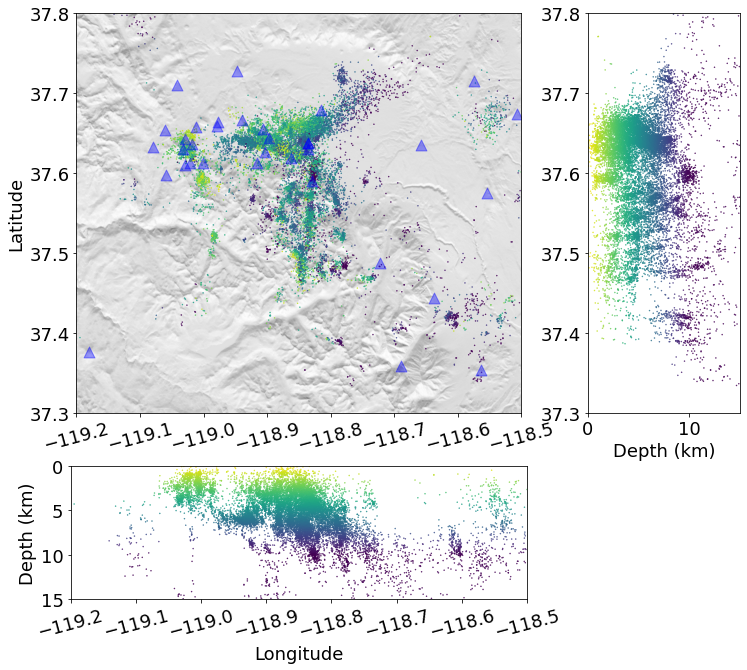

In [36]:
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.3
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"

quakeflow_catalog_origin2 = quakeflow_catalog_origin[(quakeflow_catalog_origin["longitude"]>min_longitude) & (quakeflow_catalog_origin["longitude"]<max_longitude) & (quakeflow_catalog_origin["latitude"]>min_latitude) & (quakeflow_catalog_origin["latitude"]<max_latitude) & (quakeflow_catalog_origin["depth_km"] > min_depth) & (quakeflow_catalog_origin["depth_km"] < max_depth)]
# quakeflow_catalog2 = quakeflow_catalog2.sort_values("gamma_score")

fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

# std = 2.5
# color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# color = "red"
# size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# cmap="Reds"
# cmap = "OrRd"
# cmap = "gray"
size = 0.2
color="k"
cmap="binary"
cmap = "binary"
cmap = "viridis_r"
color = quakeflow_catalog_origin2["depth_km"].clip(np.NaN, 10)
axes[0,0].scatter(quakeflow_catalog_origin2["longitude"], quakeflow_catalog_origin2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(seismic_stations["longitude"], seismic_stations["latitude"], s=120, c="b", marker="^", alpha=0.4, rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0, 0].tick_params(axis="x", labelrotation=15)
axes[0,0].set_ylabel("Latitude")

axes[0,1].scatter(quakeflow_catalog_origin2["depth_km"], quakeflow_catalog_origin2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(quakeflow_catalog_origin2["longitude"], quakeflow_catalog_origin2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].tick_params(axis="x", labelrotation=15)
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "quakeflow_catalog_origin2.pdf")
fig.savefig(figure_path / "quakeflow_catalog_origin2.png")

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


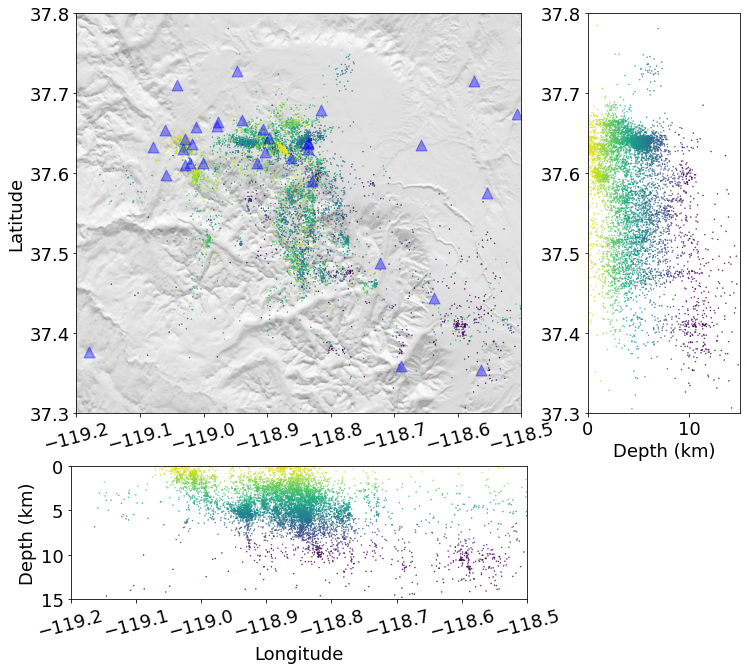

In [37]:
# sns.reset_orig()
# matplotlib.rcParams.update(params)

min_longitude = -119.2
max_longitude = -118.5
min_latitude = 37.3
max_latitude = 37.8
min_depth = -0.1
max_depth = 15
cmap = "viridis"

standard_catalog_origin2 = standard_catalog_origin[(standard_catalog_origin["longitude"]>min_longitude) & (standard_catalog_origin["longitude"]<max_longitude) & (standard_catalog_origin["latitude"]>min_latitude) & (standard_catalog_origin["latitude"]<max_latitude) & (standard_catalog_origin["depth_km"] > min_depth) & (standard_catalog_origin["depth_km"] < max_depth)]



fig, axes = plt.subplots(2, 2, figsize=(12, 12 * (max_latitude-min_latitude)/((max_longitude-min_longitude)*np.cos(np.deg2rad(min_latitude)))), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
axes[0,0].pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

# std = 2.5
# color = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std) 
# color = "red"
# size = gamma_catalog2["gamma_score"].clip(np.NaN, gamma_catalog2["gamma_score"].std()*std)/(gamma_catalog2["gamma_score"].std()*std)*5
# cmap="Reds"
# cmap = "OrRd"
# cmap = "gray"
size = 0.2
cmap = "viridis_r"
color = standard_catalog_origin2["depth_km"].clip(np.NaN, 10)

axes[0,0].scatter(standard_catalog_origin2["longitude"], standard_catalog_origin2["latitude"], s=size, c=color, cmap=cmap, alpha=1.0, label="PhaseNet-DAS", rasterized=True)
axes[0,0].autoscale(tight=True)
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()
# zlim = (0, 21)
# axes[0,0].set_title(f"Number of events: {len(events_das2)}")
axes[0, 0].scatter(seismic_stations["longitude"], seismic_stations["latitude"], s=120, c="b", marker="^", alpha=0.4, rasterized=True)
# axes[0, 0].axis("scaled")
axes[0, 0].set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
# axes[0, 0].legend(markerscale=5)
axes[0, 0].tick_params(axis="x", labelrotation=15)
axes[0,0].set_ylabel("Latitude")

axes[0,1].scatter(standard_catalog_origin2["depth_km"], standard_catalog_origin2["latitude"],  s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[0,1].autoscale(tight=True)
axes[0,1].set_ylim(ylim)
axes[0,1].set_xlim([0, max_depth])
axes[0,1].set_xlabel("Depth (km)")

axes[1,0].scatter(standard_catalog_origin2["longitude"], standard_catalog_origin2["depth_km"], s=size, c=color, cmap=cmap,  alpha=1.0, rasterized=True)
axes[1,0].autoscale(tight=True)    
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim([0, max_depth])
axes[1,0].invert_yaxis()
axes[1,0].set_ylabel("Depth (km)")
axes[1,0].tick_params(axis="x", labelrotation=15)
axes[1,0].set_xlabel("Longitude")

axes[1, 1].axis('off')
# axes[1, 1].set_xlim([0,20])
# axes[1, 1].set_ylim([0,20])
# axes[1, 1].invert_yaxis()

# fig.tight_layout()
fig.savefig(figure_path / "standard_catalog_origin2.pdf")
fig.savefig(figure_path / "standard_catalog_origin2.png")

In [ ]:
plot_location(standard_catalog, color="k", size=5, fname="figures/standard_catalog", xlim=xlim, ylim=ylim, zlim=zlim, stations=das_loc)

In [ ]:
standard_catalog2 = standard_catalog[(standard_catalog["longitude"]>min_longitude) & (standard_catalog["longitude"]<max_longitude) & (standard_catalog["latitude"]>min_latitude) & (standard_catalog["latitude"]<max_latitude) & (standard_catalog["depth_km"] > min_depth) & (standard_catalog["depth_km"] < max_depth)]

plot_location(standard_catalog2, color="k", size=10, fname="figures/standard_catalog2", xlim=xlim2, ylim=ylim2, zlim=zlim2)

In [ ]:
plot_location(hypoDD_ct_catalog, color="k", size=5, fname="figures/hypodd_catalog", xlim=xlim, ylim=ylim, zlim=zlim, stations=das_loc)

In [ ]:
hypoDD_ct_catalog2 = hypoDD_ct_catalog[(hypoDD_ct_catalog["longitude"]>min_longitude) & (hypoDD_ct_catalog["longitude"]<max_longitude) & (hypoDD_ct_catalog["latitude"]>min_latitude) & (hypoDD_ct_catalog["latitude"]<max_latitude) & (hypoDD_ct_catalog["depth_km"] > min_depth) & (hypoDD_ct_catalog["depth_km"] < max_depth)]

plot_location(hypoDD_ct_catalog2, color="k", size=10, fname="figures/hypodd_catalog2", xlim=xlim2, ylim=ylim2, zlim=zlim2, stations=das_loc)

In [42]:
# picks = pd.read_csv("mammoth_picks.csv", parse_dates=["phase_time"])
gamma_picks = pd.read_csv("gamma_picks.csv", parse_dates=["phase_time"])


In [72]:
gamma_picks = gamma_picks.sort_values("phase_time")

In [ ]:
# fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)

# axes[0].hist(picks["channel_index"], bins=100)
# axes[0].autoscale(tight=True)

# axes[1].hist(picks[picks["phase_type"] == "P"]["channel_index"], bins=100)
# axes[1].autoscale(tight=True)

# axes[2].hist(picks[picks["phase_type"] == "S"]["channel_index"], bins=100)
# axes[2].autoscale(tight=True)

In [93]:
# das_loc["picks"] = das_loc["index"].apply(lambda x: len(picks[picks["channel_index"] == x]))
gamma_picks2 = gamma_picks[gamma_picks["event_id"] != -1]
das_loc["picks"] = das_loc["index"].apply(lambda x: len(gamma_picks2[gamma_picks2["channel_index"] == x]))

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -119.22032423 to -119.220833333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -118.523626 to -118.523333333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 37.4561743054 to 37.4558333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 38.0619240402 to 38.0625


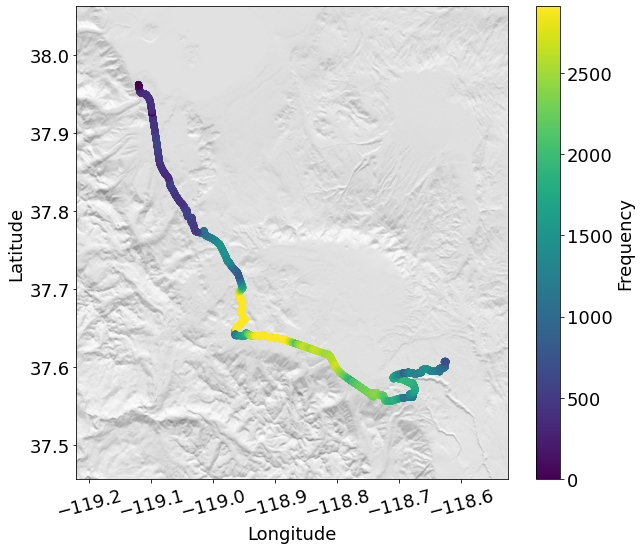

In [94]:
min_latitude, max_latitude = das_loc["latitude"].min()-0.1, das_loc["latitude"].max()+0.1
min_longitude, max_longitude = das_loc["longitude"].min()-0.1, das_loc["longitude"].max()+0.1

# fig, ax = plt.subplots(1, 1, figsize=(10, 10*(max_latitude - min_latitude)/((max_longitude - min_longitude)*np.cos(np.deg2rad(min_latitude)))))
fig, ax = plt.subplots(1, 1, figsize=(10, 10*(max_latitude - min_latitude)/(max_longitude - min_longitude)))

region = [min_longitude, max_longitude, min_latitude, max_latitude]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region).to_numpy() / 1e3  # km
x = np.linspace(min_longitude, max_longitude, topo.shape[1])
y = np.linspace(min_latitude, max_latitude, topo.shape[0])
dx, dy = 1, 1
xgrid, ygrid = np.meshgrid(x, y)
ax.pcolormesh(
    xgrid,
    ygrid,
    ls.hillshade(topo, vert_exag=10, dx=dx, dy=dy),
    vmin=-1,
    shading="gouraud",
    cmap="gray",
    alpha=1.0,
    antialiased=True,
    rasterized=True,
)

im = ax.scatter(das_loc["longitude"], das_loc["latitude"], c=das_loc["picks"], label="DAS", vmax=3*np.std(das_loc["picks"]), cmap="viridis")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.tick_params(axis="x", labelrotation=15)

ax.set_aspect(1.0/np.cos(np.deg2rad(min_latitude)))

clb = fig.colorbar(im, ax=ax)
clb.ax.set_ylabel('Frequency')

# fig.tight_layout()
fig.savefig(figure_path / "pick_frequency_along_das.pdf")
fig.savefig(figure_path / "pick_frequency_along_das.png")

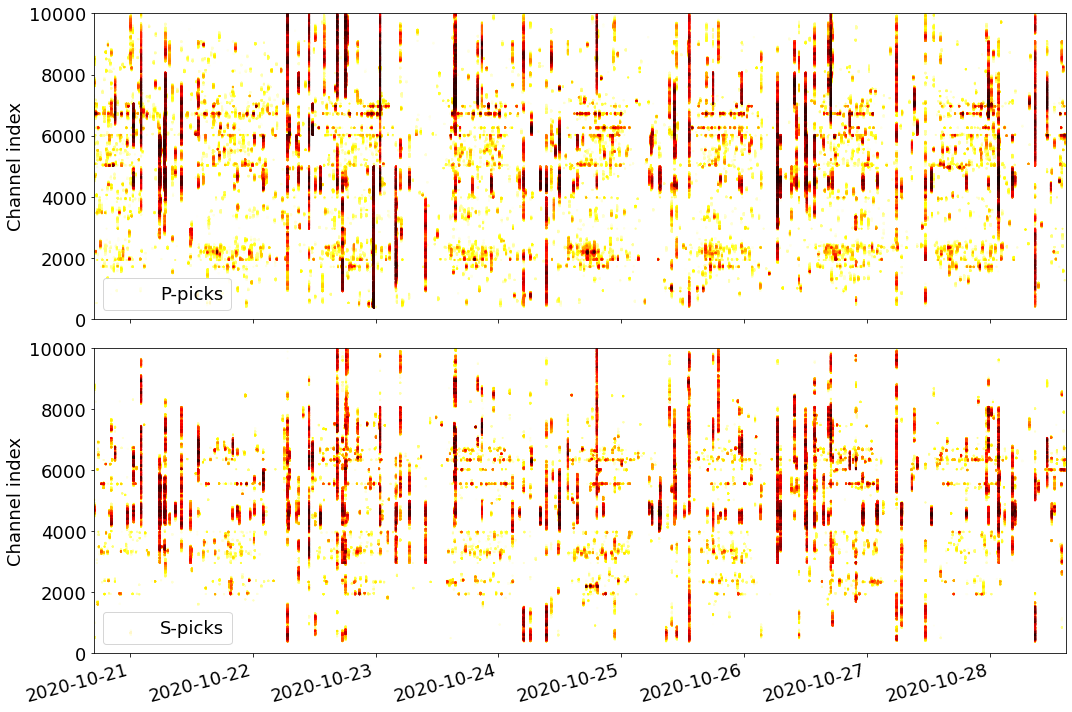

In [90]:
gamma_picks2 = gamma_picks.iloc[:1000_000]
gamma_picks2 = gamma_picks2.sort_values("phase_score")

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

axes[0].scatter(gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "P"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="P-picks", rasterized=True)
axes[0].autoscale(tight=True)
axes[0].set_ylim([0, 10_000])
axes[0].set_ylabel("Channel index")
axes[0].legend(loc="lower left")
xlim = axes[0].get_xlim()

axes[1].scatter(gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "S"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="S-picks", rasterized=True)
axes[1].autoscale(tight=True)
axes[1].set_ylim([0, 10_000])
axes[1].set_ylabel("Channel index")
axes[1].legend(loc="lower left")
axes[1].set_xlim(xlim)

fig.autofmt_xdate(rotation=15)
fig.tight_layout()

fig.savefig(figure_path / "pick_time_index.png")
fig.savefig(figure_path / "pick_time_index.pdf")

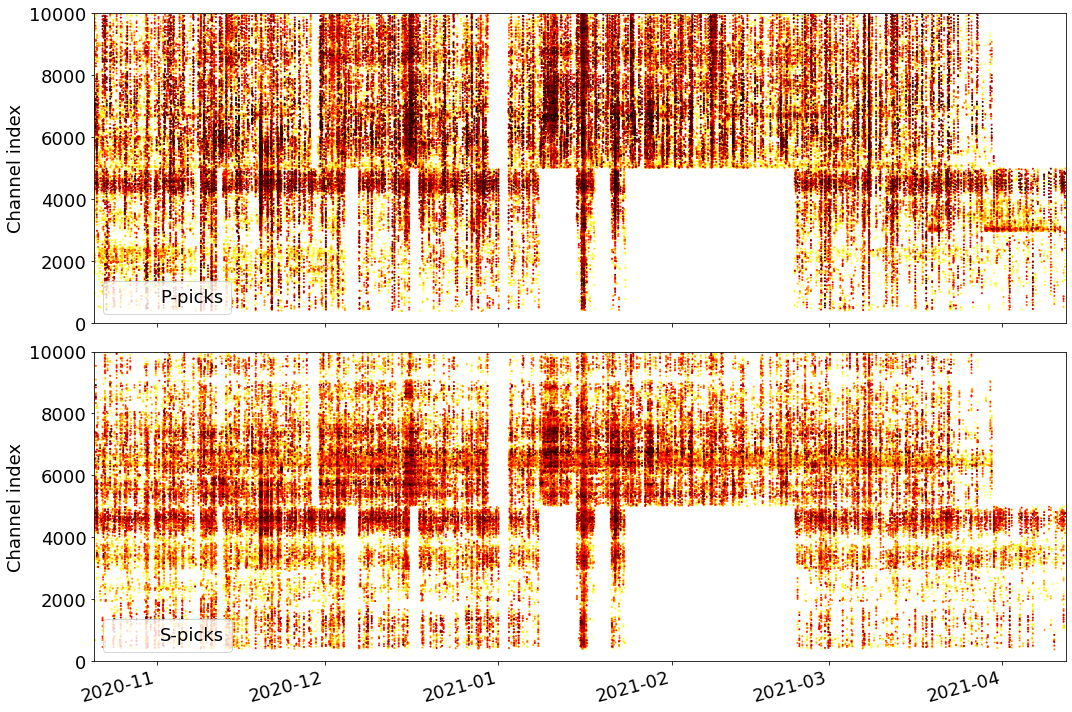

In [98]:
gamma_picks2 = gamma_picks.iloc[::100]
gamma_picks2 = gamma_picks2.sort_values("phase_score")

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

axes[0].scatter(gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "P"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="P-picks", rasterized=True)
axes[0].autoscale(tight=True)
axes[0].set_ylim([0, 10_000])
axes[0].set_ylabel("Channel index")
axes[0].legend(loc="lower left")
xlim = axes[0].get_xlim()

axes[1].scatter(gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "S"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="S-picks", rasterized=True)
axes[1].autoscale(tight=True)
axes[1].set_ylim([0, 10_000])
axes[1].set_ylabel("Channel index")
axes[1].legend(loc="lower left")
axes[1].set_xlim(xlim)

fig.autofmt_xdate(rotation=15)
fig.tight_layout()

fig.savefig(figure_path / "pick_time_index_origin.png")
fig.savefig(figure_path / "pick_time_index_origin.pdf")

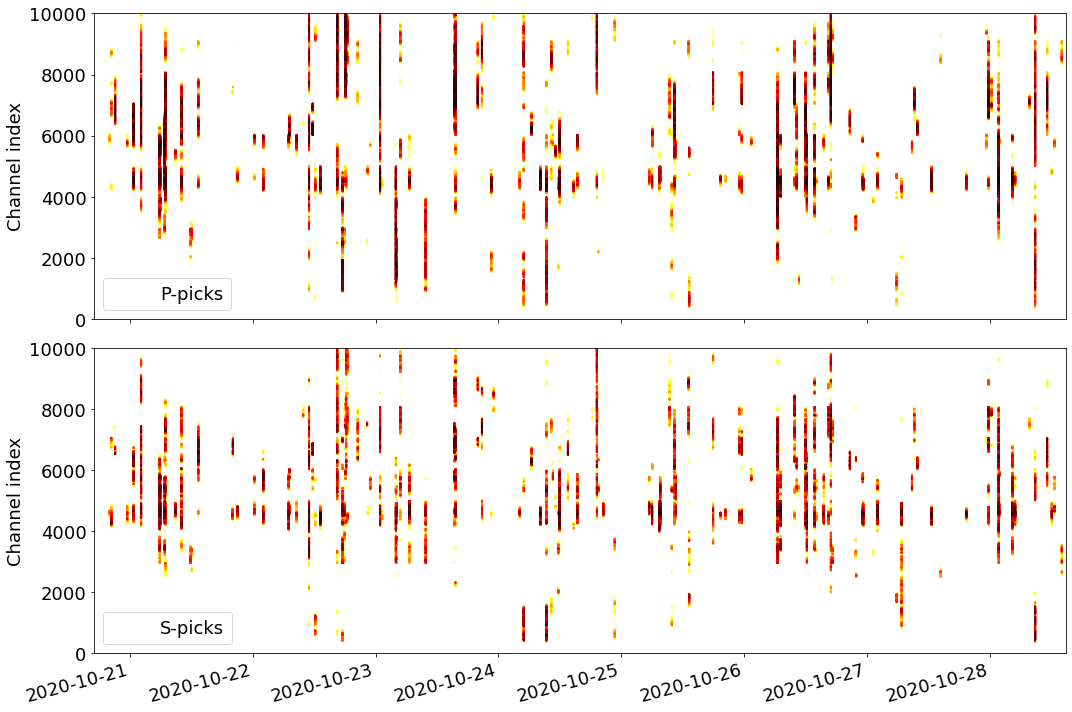

In [91]:
gamma_picks2 = gamma_picks.iloc[:1000_000]
gamma_picks2 = gamma_picks2.sort_values("phase_score")
gamma_picks2 = gamma_picks2[gamma_picks2["event_id"] != -1]

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

axes[0].scatter(gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "P"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="P-picks", rasterized=True)
axes[0].autoscale(tight=True)
axes[0].set_ylim([0, 10_000])
axes[0].set_ylabel("Channel index")
axes[0].legend(loc="lower left")
axes[0].set_xlim(xlim)

axes[1].scatter(gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "S"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_score"], s=1, cmap="hot_r", vmin=0.6, vmax=1.0, label="S-picks", rasterized=True)
axes[1].autoscale(tight=True)
axes[1].set_ylim([0, 10_000])
axes[1].set_ylabel("Channel index")
axes[1].legend(loc="lower left")
axes[1].set_xlim(xlim)

fig.autofmt_xdate(rotation=15)
fig.tight_layout()

fig.savefig(figure_path / "pick_time_index_gamma.png")
fig.savefig(figure_path / "pick_time_index_gamma.pdf")

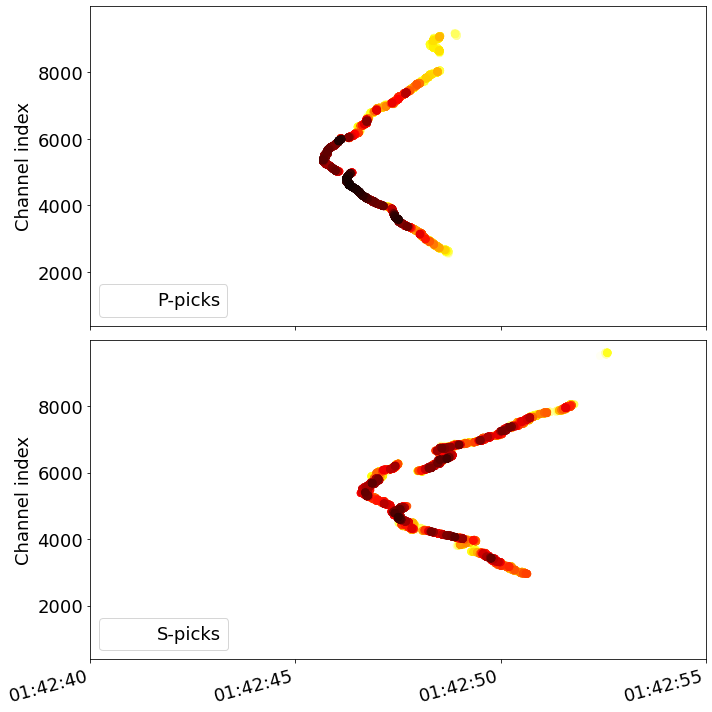

In [129]:
gamma_picks2 = gamma_picks.iloc[:1000_000]
gamma_picks2 = gamma_picks2.sort_values("phase_score")
gamma_picks2 = gamma_picks2[gamma_picks2["event_id"] != -1]

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

# tmin = datetime(2020, 10, 22, 16, 30, )
# tmax = datetime(2020, 10, 22, 16, 30, 20)

# tmin = datetime(2020, 10, 28, 1, 30, )
# tmax = datetime(2020, 10, 28, 2, 1, )

tmin = datetime(2020, 10, 28, 1, 42, 40)
tmax = datetime(2020, 10, 28, 1, 42, 55)

axes[0].scatter(gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "P"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "P"]["phase_score"], s=50, cmap="hot_r", vmin=0.6, vmax=1.0, label="P-picks", rasterized=True)
axes[0].autoscale(tight=True)
# axes[0].set_ylim([0, 10_000])
axes[0].set_ylabel("Channel index")
axes[0].legend(loc="lower left")
axes[0].set_xlim([tmin, tmax])

axes[1].scatter(gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_time"], gamma_picks2[gamma_picks2["phase_type"] == "S"]["channel_index"], c=gamma_picks2[gamma_picks2["phase_type"] == "S"]["phase_score"], s=50, cmap="hot_r", vmin=0.6, vmax=1.0, label="S-picks", rasterized=True)
axes[1].autoscale(tight=True)
# axes[1].set_ylim([0, 10_000])
axes[1].set_ylabel("Channel index")
axes[1].legend(loc="lower left")
axes[1].set_xlim([tmin, tmax])

fig.autofmt_xdate(rotation=15)
fig.tight_layout()

fig.savefig(figure_path / "pick_time_index2.png")
fig.savefig(figure_path / "pick_time_index2.pdf")